## Test best-of-call

What we want to do is to compute

$$ payoff = \max(x_1-k_1, x_2-k_2, 0)$$

In [3]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(u)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘


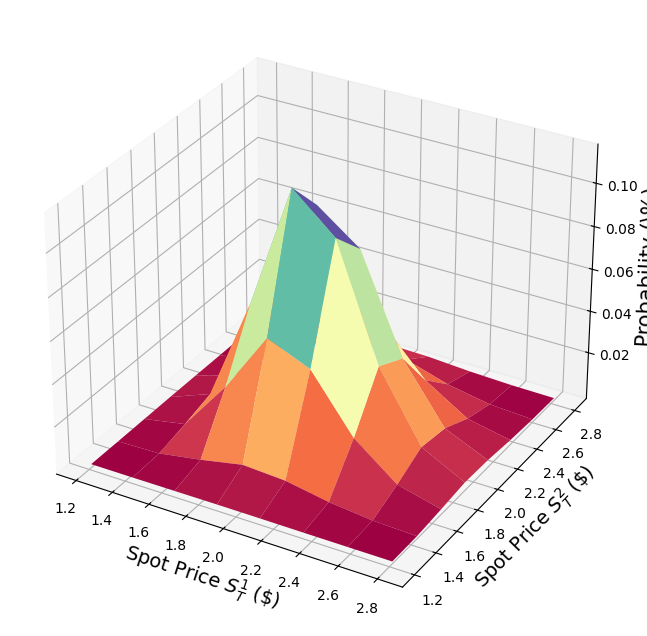

In [2]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()


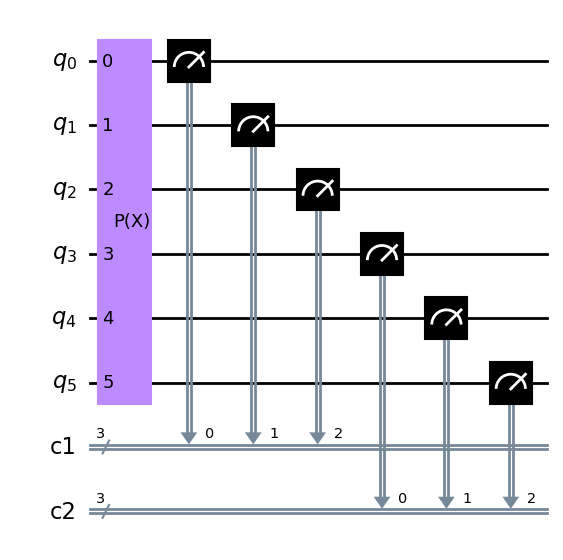

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

q_reg = QuantumRegister(u.num_qubits, name='q')
first_num_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
second_num_register = ClassicalRegister(num_uncertainty_qubits, name='c2')


test_circuit = QuantumCircuit(q_reg, first_num_register, second_num_register)
test_circuit.append(u, test_circuit.qubits)
test_circuit.measure(test_circuit.qubits[:num_uncertainty_qubits], first_num_register)
test_circuit.measure(test_circuit.qubits[num_uncertainty_qubits:], second_num_register)
test_circuit.draw(output='mpl')

{'011 111': 2, '001 111': 1, '110 110': 1, '100 000': 2, '100 110': 8, '010 101': 16, '001 011': 8, '100 111': 3, '001 101': 4, '010 111': 1, '101 010': 25, '001 010': 7, '011 110': 16, '011 001': 10, '110 001': 3, '100 001': 4, '111 010': 3, '100 011': 104, '010 110': 10, '101 001': 3, '101 100': 38, '010 001': 2, '101 011': 31, '110 101': 4, '011 101': 48, '100 100': 76, '001 100': 8, '011 011': 107, '101 101': 22, '010 100': 41, '111 011': 4, '100 101': 38, '100 010': 48, '110 111': 1, '001 110': 1, '010 011': 68, '110 011': 17, '110 010': 3, '011 010': 56, '011 100': 116, '110 100': 7, '101 110': 5, '111 100': 6, '010 010': 22}


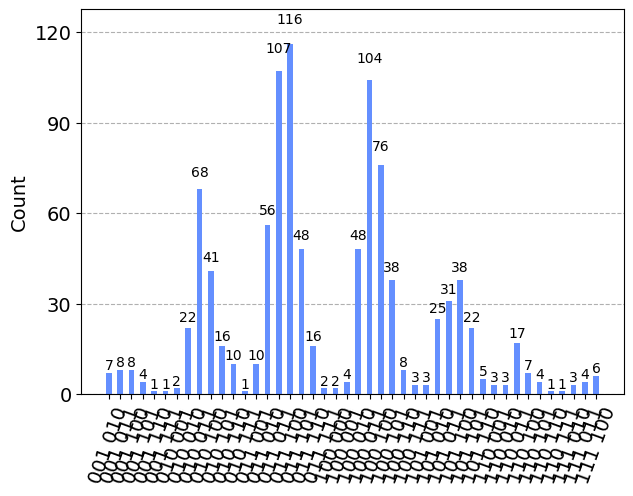

In [14]:
from qiskit import execute, Aer

job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

## strike 1

In [29]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.9

# set the approximation scaling for the payoff function
c_approx = 0.125

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_1
# maximum y value

call_objective_1 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_1)


        ┌────┐
q272_0: ┤0   ├
        │    │
q272_1: ┤1   ├
        │    │
q272_2: ┤2   ├
        │    │
  q273: ┤3 F ├
        │    │
 a27_0: ┤4   ├
        │    │
 a27_1: ┤5   ├
        │    │
 a27_2: ┤6   ├
        └────┘


## Strike 2

In [30]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_2 = 1.6

# set the approximation scaling for the payoff function
c_approx = 0.125

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_2] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_2
# maximum y value

call_objective_2 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_2)

        ┌────┐
q274_0: ┤0   ├
        │    │
q274_1: ┤1   ├
        │    │
q274_2: ┤2   ├
        │    │
  q275: ┤3 F ├
        │    │
 a30_0: ┤4   ├
        │    │
 a30_1: ┤5   ├
        │    │
 a30_2: ┤6   ├
        └────┘


## Exact payoff

In [31]:
probabilities = u.probabilities
values = u.values

expected_payoff = 0
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(f"Expected payoff: {expected_payoff:.4f}")

Expected payoff: 0.4531


# Build circuits

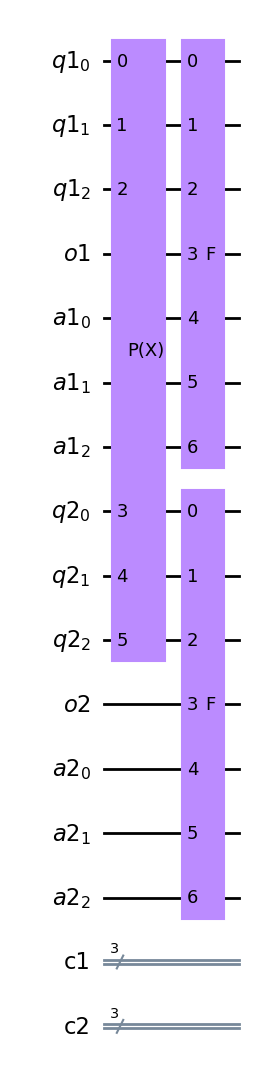

In [32]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit

first_num_register = QuantumRegister(num_uncertainty_qubits, name='q1')
second_num_register = QuantumRegister(num_uncertainty_qubits, name='q2')

first_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
second_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c2')

first_ancilla_register = AncillaRegister(num_uncertainty_qubits, name='a1')
second_ancilla_register = AncillaRegister(num_uncertainty_qubits, name='a2')

first_objective_register = QuantumRegister(1, name='o1')
second_objective_register = QuantumRegister(1, name='o2')

test_circuit = QuantumCircuit(first_num_register, first_objective_register, first_ancilla_register, second_num_register, second_objective_register, second_ancilla_register, first_classical_register, second_classical_register)

test_circuit.append(u, first_num_register[:] + second_num_register[:])
test_circuit.append(call_objective_1, first_num_register[:] + first_objective_register[:] + first_ancilla_register[:])
test_circuit.append(call_objective_2, second_num_register[:] + second_objective_register[:] + second_ancilla_register[:])


test_circuit.draw(output='mpl')
